In [3]:
import pandas
import os
import pixiedust

Pixiedust database opened successfully


### Add your paths to the synthetic_data folder

In [4]:
path_to_synthetic_data = '/Users/katiecarlson/Downloads/'

# Look at our data

In [5]:
demographics = pandas.read_csv(path_to_synthetic_data+'synthetic_data/create_v_demographic.csv', delimiter="\t")
#display(demographics)

In [6]:
#histories = pandas.read_csv(path_to_synthetic_data+'synthetic_data/create_v_medical_history.csv', delimiter="\t")
#display(histories)

In [7]:
diagnosis = pandas.read_csv(path_to_synthetic_data+'synthetic_data/create_v_diagnosis.csv', delimiter="\t")
#display(diagnosis)

In [114]:
observations = pandas.read_csv(path_to_synthetic_data+'synthetic_data/create_v_observation.csv', delimiter="\t")
display(observations)

EXPLORYS_PATIENT_ID,SOURCE_SYSTEM_TYPE,RECORD_ID_HASH,DATA_GRID_DATE_UPDATED,LOINC_TEST_ID,LOINC_CATEGORY_ID,STD_UOM,STD_VALUE,STD_VALUE_TXT,STD_REPORT_STATUS,STD_VALUE_STATUS,ENCOUNTER_RECORD_ID_HASH,ENCOUNTER_JOIN_ID,OBSERVATION_DATE,OBSERVATION_HIGH_REF,OBSERVATION_LOW_REF
00013D2EFD8E45D1,BILLING,00013D2EFD8E45D1,2016-03-03 19:37:07,5902-2,nan,nan,nan,nan,Ordered,nan,542192281063886,542192281063886,2008-09-04 00:00:00,nan,nan
00013D2EFD8E45D1,BILLING,00013D2EFD8E45D1,2016-03-03 19:37:07,29463-7,nan,kg,75.0,random generated weight,Complete,nan,542192281063886,542192281063886,2008-09-04 00:00:00,nan,nan
00013D2EFD8E45D1,BILLING,00013D2EFD8E45D1,2016-03-03 19:37:07,8302-2,nan,cm,179.0,random generated height,Complete,nan,542192281063886,542192281063886,2008-09-04 00:00:00,nan,nan
00013D2EFD8E45D1,BILLING,00013D2EFD8E45D1,2016-03-03 19:37:07,8310-5,nan,C,36.7,random generated body temp,Complete,nan,542192281063886,542192281063886,2008-09-04 00:00:00,nan,nan
00013D2EFD8E45D1,BILLING,00013D2EFD8E45D1,2016-03-03 19:37:07,8462-4,nan,mmHg,59.0,random generated diastolic,Complete,nan,542192281063886,542192281063886,2008-09-04 00:00:00,nan,nan
00013D2EFD8E45D1,BILLING,00013D2EFD8E45D1,2016-03-03 19:37:07,8480-6,nan,mmHg,139.0,random generated systolic,Complete,nan,542192281063886,542192281063886,2008-09-04 00:00:00,nan,nan
00013D2EFD8E45D1,BILLING,00013D2EFD8E45D1,2016-03-03 19:37:07,8867-4,nan,bpm,65.0,random generated heart rate,Complete,nan,542192281063886,542192281063886,2008-09-04 00:00:00,nan,nan
00013D2EFD8E45D1,BILLING,00013D2EFD8E45D1,2016-03-03 19:37:07,9279-1,nan,breaths/min,15.0,random generated resp rate,Complete,nan,542192281063886,542192281063886,2008-09-04 00:00:00,nan,nan
00013D2EFD8E45D1,BILLING,00013D2EFD8E45D1,2016-03-03 19:37:07,4548-4,nan,%,5.9,random generated HBA1C,Complete,nan,542192281063886,542192281063886,2008-09-04 00:00:00,nan,nan
00013D2EFD8E45D1,BILLING,00013D2EFD8E45D1,2016-03-03 19:37:07,48643-1,nan,mLmin,133.0,random generated eGFR,Complete,nan,542192281063886,542192281063886,2008-09-04 00:00:00,nan,nan


# Make sure pixie app is installed

In [9]:
# Uncomment to install pixiedust_health from a local repository
# ATTN: replace with your path to the pixiedust_health repository
#!pip install -e /Users/elizabethwells/PycharmProjects/WatsonHealth/pixiedust_health

In [11]:
from pixiedust_health import *
#PixieHealthApp().run(runInDialog='true')

# Create Cohorts class

In [130]:
import os
from collections import defaultdict
from six import iteritems
import pandas
from datetime import datetime
from dateutil.relativedelta import relativedelta

# Hopefully find a better way to do this if we expand to other diseases
diseaseMap = {1: {'DisplayName': 'Diabetes', 'SnomedIDs': ['44054006', '359642000','81531005','237599002','199230006','609567009','237627000',
                        '9859006','190331003','703138006','314903002','314904008','190390000','314772004',
                        '314902007','190389009','313436004','1481000119100'], 'LoincIDs': ['4548-4', '29463-7','8302-2'], 'Features': ['HBA1C','WEIGHT','HEIGHT']}, 
              2: {'DisplayName': 'Hypertension', 'SnomedIDs': ['38341003'], 'LoincIDs': [], 'Features': ['BLOOD_PRESSURE']}}


# Class for storing data and generating DataFrames and matrices for UI and machine learning
# Requires 3 pandas data frames from create_v_demographic.csv, create_v_diagnosis.csv, and create_v_observation.csv
# Columns expected in demogaphics: 'EXPLORYS_PATIENT_ID', 'STD_GENDER', 'BIRTH_YEAR', 'STD_RACE'
# Columns expected in diagnosis: 'EXPLORYS_PATIENT_ID', 'DIAGNOSIS_DATE', 'SNOMED_IDS'
# Columns expected in observations: 'EXPLORYS_PATIENT_ID', 'LOINC_TEST_ID', 'STD_VALUE'
class Cohorts:
    
    #--------------------------------------- PRIVATE METHODS ---------------------------------------#
    
    ##-------------------------------------- Initialization --------------------------------------##
    
#     def __init__(self, pathToData):
    def __init__(self, demographics, diagnosis, observations):
#         demographics = pandas.read_csv(pathToData + '/create_v_demographic.csv', delimiter="\t")
        print "demographics starting"
        self.demographics = self.__filterDemographics(demographics)
        print "demographics done"
        
#         diagnosis = pandas.read_csv(pathToData + '/create_v_diagnosis.csv', delimiter="\t")
        print "diagnosis starting"
        self.diagnosis = self.__filterDiagnosis(diagnosis)
#         self.diagnosis = self.__filterDiagnosis(diagnosis)
#         self.histories, self.diagnosis = self.__filterDiagnosis(diagnosis)
        print "diagnosis done"
        
#         observations = pandas.read_csv(pathToData + '/create_v_observation.csv', delimiter="\t")
        print "observations starting"
        self.observations = self.__getObservations(observations)
        print "observations done"

        self.demographicsFeatures = self.__getDemographicFeatures(observations)
        
    # Returns filtered demographics data frame
    # Requires original demographics chart
    # Used in initial processing of data
    def __filterDemographics(self, demographics):
        filteredDemographics = demographics[['EXPLORYS_PATIENT_ID', 'STD_GENDER', 'BIRTH_YEAR', 'STD_ETHNICITY', 'STD_RACE']]
        filteredDemographics["BIRTH_YEAR"] = filteredDemographics.apply(lambda row: 2017 - row["BIRTH_YEAR"],axis=1)
        filteredDemographics.rename(columns={'BIRTH_YEAR':'AGE'}, inplace=True)
        
        # ethnicity to indices
        dict_ethnicity = {'hispanic':1, 'non-hispanic':2, 'other':3, 'declined':4, 'unknown':4}
        filteredDemographics["STD_ETHNICITY"].replace(dict_ethnicity, inplace=True)
        # race to indices
        dict_race = {101:1, 615:2, 203:3, 699:4}
        filteredDemographics["STD_RACE"].replace(dict_race, inplace=True)
        
        return filteredDemographics
    

    
    # Returns diagnosis history data frame
    # Requires original diagnosis histories chart
    # Used in initial processing of data
    def __filterDiagnosis(self, diagnosis):
        filteredDiagnosis = diagnosis[['EXPLORYS_PATIENT_ID', 'DIAGNOSIS_DATE', 'SNOMED_IDS']]
        snomedIDs = filteredDiagnosis['SNOMED_IDS'].map(lambda x: tuple(x.split(',')) if isinstance(x, str) else tuple())
        filteredDiagnosis['SNOMED_IDS'] = snomedIDs.values
        filteredDiagnosis = filteredDiagnosis.groupby(['EXPLORYS_PATIENT_ID', 'DIAGNOSIS_DATE'], as_index=False).sum()
        return filteredDiagnosis
       
    # Returns the BMI of a patient given their information in demographics
    # Designed to be used in the apply function in getFeatures()
    def __bmi(self, row):
        return (row['WEIGHT'] / row['HEIGHT']**2) * 10000
    
    def __getObservations(self, observations):
        filteredObservations = observations[['EXPLORYS_PATIENT_ID', 'LOINC_TEST_ID', 'STD_VALUE', 'OBSERVATION_DATE']]
        return filteredObservations
    
    # Returns filtered observation data frame
    # Requires original observations chart
    # Used in initial processing of data
    def __getDemographicFeatures(self, observations):
        demographicCopy = self.demographics
        filteredObservations = observations[['EXPLORYS_PATIENT_ID', 'LOINC_TEST_ID', 'STD_VALUE']]
        filteredObservations = filteredObservations.groupby(['EXPLORYS_PATIENT_ID', 'LOINC_TEST_ID'], as_index=False).mean()
        loincIDs = [('HBA1C', '4548-4'), ('WEIGHT', '29463-7'), ('HEIGHT', '8302-2')]
        for label, loinc in loincIDs:
            justThisLabel = filteredObservations.loc[filteredObservations['LOINC_TEST_ID'] == loinc]
            justThisLabel = justThisLabel.rename(columns={'STD_VALUE': label})
            demographicCopy = demographicCopy.merge(justThisLabel.drop('LOINC_TEST_ID', 1))
        bmis = demographicCopy[['WEIGHT', 'HEIGHT']].apply(self.__bmi, axis=1)
        demographicCopy['BMI'] = bmis.values
        return demographicCopy
    
    ##------------------------ Utility functions for filtering by disease ------------------------##
    
    # Returns a list of all patients we have a medical history for
    # Facilitates getPatientsWithoutDisease()
    def __getPatients(self):
        return set(self.diagnosis['EXPLORYS_PATIENT_ID'].values)
    
    # Returns list of IDs for patients with a given disease
    # Requires disease ID
    # Facilitates getDemographics() and used in machine learning component
    def __getPatientsWithDisease(self, diseaseID):
        snomedIDs = diseaseMap[diseaseID]['SnomedIDs']
        filtered = self.diagnosis.loc[[not (set(item).isdisjoint(snomedIDs)) for item in self.diagnosis['SNOMED_IDS']]]
        return set(filtered['EXPLORYS_PATIENT_ID'].values)
    
    # Returns list of IDs for patients without a given disease
    # Requires disease ID
    # Facilitates getDemographics() and used in machine learning component
    def __getPatientsWithoutDisease(self, diseaseID):
        return self.__getPatients() - self.__getPatientsWithDisease(diseaseID)
    
        #-----------------------------------------------------------------------------------------#
        
    # Returns the first date (if multiple) that a patient has recorded corresponding to SNOMED for diseaseID
    def __getDiagnosisDate(self, patientID, diseaseID):
        patient_diagnosis = self.diagnosis.loc[self.diagnosis['EXPLORYS_PATIENT_ID'] == patientID]
        snomedIDs = diseaseMap[diseaseID]['SnomedIDs']
        filtered = patient_diagnosis.loc[[not (set(item).isdisjoint(snomedIDs)) for item in patient_diagnosis['SNOMED_IDS']]]
        return min(list(set(filtered['DIAGNOSIS_DATE'].values)))  
    
    # Returns the observation table filtered on single loincID -- used in calculating average features
    def __getFilteredLoinc(self, loincID):
        filtered_obs = self.observations.loc[self.observations['LOINC_TEST_ID'] == loincID]
        # convert observation dates to datetime
        filtered_obs['OBSERVATION_DATE'] = filtered_obs.apply(lambda row: (datetime.strptime(row['OBSERVATION_DATE'], '%Y-%m-%d %H:%M:%S')),axis=1)
        return filtered_obs

    # Returns dataframe for patients with diseaseID from diagnosis table, and date/prev year date in datetime object form
    def __filterDiagnosisDateForDisease(self, diseaseID):
        snomedIDs = diseaseMap[diseaseID]['SnomedIDs']
        filtered = self.diagnosis.loc[[not (set(item).isdisjoint(snomedIDs)) for item in self.diagnosis['SNOMED_IDS']]]
        filtered.drop('SNOMED_IDS',axis=1, inplace=True)
        filtered['DIAGNOSIS_DATE'] = filtered.apply(lambda row: datetime.strptime(row['DIAGNOSIS_DATE'], '%Y-%m-%d %H:%M:%S'),axis=1)
        min_diagnosis_date = filtered.loc[filtered.groupby("EXPLORYS_PATIENT_ID")["DIAGNOSIS_DATE"].idxmin()]
        min_diagnosis_date['ONE_YEAR_PREV'] = min_diagnosis_date.apply(lambda row: (row['DIAGNOSIS_DATE'] - relativedelta(years=1)),axis=1)
        return min_diagnosis_date
    
    # Returns dataframe with LOINC ID feature values averaged for the observations in the 12 months prior to diagnosis
    def __getAvgFeatures(self,diseaseID, loincID, label):
        # returns df for patients with loincID from observation table
        patient_obs = self.__getFilteredLoinc(loincID)
        # returns df for patients with diseaseID from diagnosis table
        pos_diagnosis_dates = self.__filterDiagnosisDateForDisease(diseaseID)
        # join the filtered obs and diagnosis table to get patients with data in both
        obs_diag_merge = patient_obs.merge(pos_diagnosis_dates, how='inner', on='EXPLORYS_PATIENT_ID')
        # gets people with diagnosis date and with the features needed for the disease
        # filter out observations for patients not in year prior to diagnosis date
        obs_diag_merge[obs_diag_merge.apply(lambda row: row['ONE_YEAR_PREV']<=row['OBSERVATION_DATE']<=row['DIAGNOSIS_DATE'],axis=1)]
        obs_diag_merge.drop(['LOINC_TEST_ID', 'DIAGNOSIS_DATE', 'ONE_YEAR_PREV'],axis=1, inplace=True)
        # calculate average value for patients with records on the same day
        obs_avg_day = (obs_diag_merge.groupby(['EXPLORYS_PATIENT_ID', 'OBSERVATION_DATE'])).mean().reset_index()
        obs_avg_day.drop(['OBSERVATION_DATE'],axis=1, inplace=True)
        # calculate average value for each patient (12mos prior to diagnosis)
        obs_avg_patient = obs_avg_day.groupby(['EXPLORYS_PATIENT_ID']).mean().reset_index()
        obs_avg_patient.rename(columns={'STD_VALUE':label}, inplace=True)
        return obs_avg_patient

    # Returns dataframe with demographics joined with LOINC ID features for patients positive for a disease
    def __getPosSetFeatures(self, diseaseID, features=None):
        loincIDs = [('HBA1C', '4548-4'), ('WEIGHT', '29463-7'), ('HEIGHT', '8302-2')]
        # get demographics table for people with disease
        features = self.getDemographics(diseaseID)['pos'].drop(['HBA1C', 'WEIGHT', 'HEIGHT', 'BMI'], axis=1)
        for label, loincID in loincIDs:
            avg_loinc = self.__getAvgFeatures(diseaseID, loincID, label)
            # merge tables for loinc features and demographics -> feature vectors for positive set
            features = avg_loinc.merge(features, how='inner', on='EXPLORYS_PATIENT_ID')
        features['BMI'] = features.apply(self.__bmi,axis=1)
        return features

    # Returns dataframe with the most recent LOINC ID feature value for patients without the disease
    def __getNegLoincFeature(self, diseaseID, loincID, label):
        #loincID = diseaseMap[diseaseID]['LoincIDs'][featureIdx]
        # returns df for patients with loincID from observation table
        patient_obs = self.__getFilteredLoinc(loincID)
        # filter patients who don't have any observations for the features corresponding to the disease
        negIDs = self.__getPatientsWithoutDisease(diseaseID)
        neg_obs = patient_obs[patient_obs['EXPLORYS_PATIENT_ID'].isin(negIDs)]
        # get most recent date for observation of loinc feature
        recent_obs_date = neg_obs.loc[neg_obs.groupby("EXPLORYS_PATIENT_ID")["OBSERVATION_DATE"].idxmax()]
        recent_obs_date.drop(['LOINC_TEST_ID', 'OBSERVATION_DATE'],axis=1, inplace=True)
        recent_obs_date.rename(columns={'STD_VALUE':label}, inplace=True)
        return recent_obs_date
    
    # Returns dataframe with demographics joined with LOINC ID features for patients negative for a disease
    def __getNegSetFeatures(self, diseaseID):
        loincIDs = [('HBA1C', '4548-4'), ('WEIGHT', '29463-7'), ('HEIGHT', '8302-2')]
        # get demographics table for people with disease
        features = self.getDemographics(diseaseID)['neg'].drop(['HBA1C', 'WEIGHT', 'HEIGHT', 'BMI'], axis=1)
        for label, loincID in loincIDs:
            loinc_feature = self.__getNegLoincFeature(diseaseID, loincID, label)
            # merge tables for loinc features and demographics -> feature vectors for positive set
            features = loinc_feature.merge(features, how='inner', on='EXPLORYS_PATIENT_ID')
        features['BMI'] = features.apply(self.__bmi,axis=1)
        return features
    
    #--------------------------------------- PUBLIC METHODS ---------------------------------------#
    
    # Returns list of (DisplayName, ID) for all diseases we have data for
    # Designed for drop-down menu in initial window of UI
    # Example return: [('Diabetes', 1), ('Hypertension', 2)]
    def getDiseases(self):
        return [(value['DisplayName'], key) for key, value in iteritems(diseaseMap)]
    
    # Returns a dictionary of Data Frames, one for demographics and stats for patients with the given disease (key 'pos') 
    #   and one for patients who don't have that disease (key 'neg')
    # Columns in returned data frames: 'EXPLORYS_PATIENT_ID', 'STD_GENDER', 'STD_ETHNICITY', 'STD_RACE', 'AGE', 'HBA1C', 'WEIGHT', 'HEIGHT', 'BMI'
    # Had to calculate age  from birth year and BMI from weight and height
    # Designed for descriptive analytics window of UI and to use in getFeatureVectors()
    # This part is split into 2 separate data frames so the information shown in the pixieapp is just the people with the disease
    def getDemographics(self, diseaseID):
        pos_patients = self.__getPatientsWithDisease(diseaseID)
        neg_patients = self.__getPatientsWithoutDisease(diseaseID)
        pos_demographics = self.demographicsFeatures.loc[self.demographicsFeatures['EXPLORYS_PATIENT_ID'].isin(pos_patients)]
        neg_demographics = self.demographicsFeatures.loc[self.demographicsFeatures['EXPLORYS_PATIENT_ID'].isin(neg_patients)]
        return {'pos': pos_demographics, 'neg': neg_demographics}

    
    # Returns a data frame including both patients with and without given disease
    # HAS_DISEASE column indicates whether a patient has the disease (1) or not (0)
    # Returns only certain features if features are specified
    # Columns returned by default: 'STD_GENDER', 'AGE', 'STD_ETHNICITY', 'STD_RACE', 'HBA1C', 'WEIGHT', 'HEIGHT', 'BMI', 'HAS_DISEASE'
    # Out of the positive and negative patients, the bigger group is cut down to be the same size as the smaller group
    # Used in machine learning component
    def getFeatureVectors(self, diseaseID):
        pos_features = self.__getPosSetFeatures(diseaseID)
        neg_features = self.__getNegSetFeatures(diseaseID)
        size = min(len(pos_features.index), len(neg_features.index))
        pos_features = pos_features.sample(n=size)
        pos_features['HAS_DISEASE'] = 1
        neg_features = neg_features.sample(n=size)
        neg_features['HAS_DISEASE'] = 0
        data = pandas.concat([pos_features, neg_features])
        return data
    
    # Returns a data frame including both patients with and without given disease to be fed into the model 
    # Purpose of this function is to accomodate the ability to select features in the app without the need to recompute all columns
    # Columns returned by default: 'STD_GENDER', 'AGE', 'STD_ETHNICITY', 'STD_RACE', 'HBA1C', 'WEIGHT', 'HEIGHT', 'BMI', 'HAS_DISEASE'
    # features argument must be some subset of the default columns in an array (that you wish to include)
    def getFeaturesForModel(self, data, features=None):
        if features != None:
            features.insert(0, 'EXPLORYS_PATIENT_ID')
            features.append('HAS_DISEASE')
            return data[features]
        return data

    

In [126]:
import time
start_time = time.time()
cohorts = Cohorts(demographics, diagnosis, observations)
print("- %s seconds -" % (time.time() - start_time))

demographics starting


/Users/katiecarlson/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


demographics done
diagnosis starting


/Users/katiecarlson/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


diagnosis done
observations starting
observations done
- 75.8596031666 seconds -


In [127]:
start_time = time.time()
diabetes = 1
data = cohorts.getFeatureVectors(diabetes)
print("- %s seconds -" % (time.time() - start_time))

/Users/katiecarlson/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/katiecarlson/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/katiecarlson/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

- 326.618093967 seconds -


In [128]:
display(data)

EXPLORYS_PATIENT_ID,HEIGHT,WEIGHT,HBA1C,STD_GENDER,AGE,STD_ETHNICITY,STD_RACE,BMI,HAS_DISEASE
CFB92F8A43E44E64,161.277777778,75.7777777778,5.67222222222,1,74,3,1,29.1335094808,1
42EBCB2719A4E246,156.022222222,74.2222222222,5.45111111111,2,96,2,1,30.4902534547,1
746468BA0356F896,158.683673469,76.0918367347,4.91836734694,2,91,4,1,30.2185468429,1
2171A2FAC71C3015,145.281746032,76.4087301587,5.07103174603,1,91,4,3,36.2010261231,1
7C9FFCAC19D80189,153.055555556,82.6666666667,5.97222222222,1,96,4,1,35.2884213161,1
B2F94284E74AE55A,107.0,77.0,5.1,2,80,3,1,67.254782077,1
711886A7DA3AA297,152.656593407,70.3351648352,5.74688644689,2,68,3,3,30.1815386453,1
E02F20FDC722259E,161.833333333,64.8333333333,6.31666666667,2,87,2,1,24.7549692896,1
690405C4BC514E95,154.291666667,68.25,5.625,2,95,4,1,28.6693413147,1
69FB771B888D38C4,122.0,68.0,5.3,2,43,2,3,45.6866433754,1


In [142]:
#[item.encode('utf8') for item in data.columns]
len(data.columns)
#data[data.columns]
features = [item.encode('utf8') for item in data.columns]
len(features)
features[1:len(features)-1]

['HEIGHT',
 'WEIGHT',
 'HBA1C',
 'STD_GENDER',
 'AGE',
 'STD_ETHNICITY',
 'STD_RACE',
 'BMI']

# ------------------------------------------------------------


# MODEL

In [110]:
## FUNCTION

import numpy as np
from sklearn.ensemble import RandomForestClassifier


# Returns training and testing data and label sets split 80/20
# in the order: training data, training labels, testing data, testing labels
# data is the table returned from getFeaturesForModel()
def getTrainTestSets(data):
    ## CREATE TRAINING SET
    data['is_train'] = np.random.uniform(0, 1, len(data)) <= .80
    ## SPLIT INTO TRAINING AND TESTING SETS
    x_train, x_test = data[data['is_train']==True], data[data['is_train']==False]
    y_train = x_train['HAS_DISEASE']
    y_test = x_test['HAS_DISEASE']
    return x_train, y_train, x_test, y_test

# Returns array of the features to be used in the model from the data set
# data is the table returned from getFeaturesForModel()
def getFeatureNames(data):
    # Create a list of the feature column's names
    features = [item.encode('utf8') for item in data.columns]
    features = features[1:len(features)-1]

# Returns trained 
# takes in formatted data frame for people with and without the disease from cohorts class
# data is output of getFeaturesForModel()
def getRandomForestClassifier(data):
    # Create a random forest classifier. By convention, clf means 'classifier'
    clf = RandomForestClassifier(n_jobs=2)
    # Train the classifier to take the training features and learn how they relate to the training y
    clf.fit(x_train[features], y_train) #The classifier model itself is stored in the clf variable.
    # Apply the classifier we trained to the test data
    clf.predict(x_test[features])
    # View the predicted probabilities of the first 10 observations
    clf.predict_proba(x_test[features])[0:10]
    # View the predicted probabilities of the first 10 observations
    clf.predict_proba(x_test[features])[0:10]
    preds = clf.predict(x_test[features])
    preds_train = clf.predict(x_train[features])
    
## Returns feature importance as determined by the trained model
# clf is the variable the classifier is stored in
def featureImportance(clf, x_train, features):
    # View a list of the features and their importance scores
    return list(zip(x_train[features], clf.feature_importances_))

def getClassifierMetrics(clf, )


    
## CREATE TRAINING SET
import numpy as np
data['is_train'] = np.random.uniform(0, 1, len(data)) <= .80
data

## SPLIT INTO TRAINING AND TESTING SETS
x_train, x_test = data[data['is_train']==True], data[data['is_train']==False]
# Show the number of observations for the test and training dataframes
print('Number of observations in the training data:', len(x_train))
print('Number of observations in the test data:',len(x_test))

## PREPROCESS DATA
# Create a list of the feature column's names
features = data.columns[1:6]
features = [item.encode('utf8') for item in features]


## PRELIMINARIES
# Load scikit's random forest classifier library
from sklearn.ensemble import RandomForestClassifier
y_train = x_train['HAS_DISEASE']
y_test = x_test['HAS_DISEASE']

## TRAIN THE RANDOM CLASSIFIER
# Create a random forest classifier. By convention, clf means 'classifier'
clf = RandomForestClassifier(n_jobs=2)

# Train the classifier to take the training features and learn how they relate to the training y
clf.fit(x_train[features], y_train) #The classifier model itself is stored in the clf variable.

## APPLY CLASSIFIER TO TEST DATA
# Apply the classifier we trained to the test data
clf.predict(x_test[features])
# View the predicted probabilities of the first 10 observations
clf.predict_proba(x_test[features])[0:10]
# View the predicted probabilities of the first 10 observations
clf.predict_proba(x_test[features])[0:10]

## EVALUATE CLASSIFIER
preds = clf.predict(x_test[features])
# View the PREDICTED species for the first five observations
preds[0:5]
# View the ACTUAL species for the first five observations
y_test.head()
preds_train = clf.predict(x_train[features])

## CREATE A CONFUSION MATRIX
pandas.crosstab(y_test, preds, rownames=['Actual Diagnosis'], colnames=['Predicted Diagnosis'])
pandas.crosstab(y_train, preds_train, rownames=['Actual Diagnosis'], colnames=['Predicted Diagnosis'])

## VIEW FEATURE IMPORTANCE
# View a list of the features and their importance scores
list(zip(x_train[features], clf.feature_importances_))


## CROSS VALIDATION LEARN
from sklearn.model_selection import cross_val_score
x_set = data[features]
y_set = data['HAS_DISEASE']
cross_val_score(clf, x_set, y_set, cv=10)

array([ 0.91671615,  0.91193941,  0.91268191,  0.91565192,  0.91787942,
        0.91104841,  0.90733591,  0.91238491,  0.90956341,  0.91535492])

# ------------------------------------------------------------


# MODEL split up

## Create training set

In [50]:
import numpy as np

In [51]:
data['is_train'] = np.random.uniform(0, 1, len(data)) <= .80
#data

,EXPLORYS_PATIENT_ID,HBA1C,WEIGHT,STD_GENDER,AGE,STD_ETHNICITY,STD_RACE,HAS_DISEASE,is_train
9383,3F8C3AC490529EA5,5.559259,74.648148,2,60,4,1,1,True
780,053132BAB1E8B292,5.781111,79.838889,1,84,4,1,1,True
19009,822BE448936BC89B,5.647436,73.423077,2,108,2,1,1,False
4645,1F4DE918B633FCAC,5.414722,71.806944,1,79,1,2,1,True
11748,4F25BA302D0B165B,6.350000,73.000000,2,93,3,1,1,True
27004,BA327A669A7D2341,5.750000,69.644444,2,80,2,3,1,False
15425,68DD9659EA093F3C,5.509524,73.476190,2,86,1,1,1,True
13392,5A8766E92710E9B1,5.980000,85.400000,1,78,4,1,1,True
1731,0B78E24C20A56B48,5.526508,71.749524,1,64,4,1,1,True
34972,F13FCC2628CF0070,5.090000,73.100000,2,83,4,1,1,True


## Split into training and testing sets

In [52]:
x_train, x_test = data[data['is_train']==True], data[data['is_train']==False]

In [108]:
#x_train

In [109]:
#x_test

In [55]:
# Show the number of observations for the test and training dataframes
print('Number of observations in the training data:', len(x_train))
print('Number of observations in the test data:',len(x_test))

('Number of observations in the training data:', 53902)
('Number of observations in the test data:', 13440)


## Preprocess Data

In [60]:
# Create a list of the feature column's names
features = data.columns[1:6]

features = [item.encode('utf8') for item in features]
features

['HBA1C', 'WEIGHT', 'STD_GENDER', 'AGE', 'STD_ETHNICITY']

## Preliminaries

In [61]:
# Load the library with the iris dataset
#from sklearn.datasets import load_iris

# Load scikit's random forest classifier library
from sklearn.ensemble import RandomForestClassifier

In [62]:
y_train = x_train['HAS_DISEASE']
y_test = x_test['HAS_DISEASE']

## Train The Random Forest Classifier

In [63]:
# Create a random forest classifier. By convention, clf means 'classifier'
clf = RandomForestClassifier(n_jobs=2)

# Train the classifier to take the training features and learn how they relate
# to the training y (the species)
clf.fit(x_train[features], y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=2, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [64]:
#The classifier model itself is stored in the clf variable.

## Apply classifier To Test Data

In [65]:
# Apply the classifier we trained to the test data (which, remember, it has never seen before)
clf.predict(x_test[features])

array([1, 1, 1, ..., 0, 0, 0])

In [66]:
# View the predicted probabilities of the first 10 observations
clf.predict_proba(x_test[features])[0:10]

array([[ 0. ,  1. ],
       [ 0.1,  0.9],
       [ 0. ,  1. ],
       [ 0. ,  1. ],
       [ 0.2,  0.8],
       [ 0. ,  1. ],
       [ 0. ,  1. ],
       [ 0. ,  1. ],
       [ 0. ,  1. ],
       [ 0. ,  1. ]])

## Evaluate classifier

In [67]:
# Create actual english names for the plants for each predicted plant class
#has_disease = np.array(['False', 'True'])
preds = clf.predict(x_test[features])

In [68]:
# View the PREDICTED species for the first five observations
preds[0:5]

array([1, 1, 1, 1, 1])

In [69]:
# View the ACTUAL species for the first five observations
y_test.head()

19009    1
27004    1
26862    1
16754    1
27793    1
Name: HAS_DISEASE, dtype: int64

In [70]:
preds_train = clf.predict(x_train[features])

## Create a confusion matrix

In [71]:
# Create confusion matrix
pandas.crosstab(y_test, preds, rownames=['Actual Diagnosis'], colnames=['Predicted Diagnosis'])

Predicted Diagnosis,0,1
Actual Diagnosis,,
0,6366,365
1,849,5860


In [72]:
pandas.crosstab(y_train, preds_train, rownames=['Actual Diagnosis'], colnames=['Predicted Diagnosis'])

Predicted Diagnosis,0,1
Actual Diagnosis,,
0,26871,69
1,520,26442


## View Feature Importance

In [73]:
# View a list of the features and their importance scores
list(zip(x_train[features], clf.feature_importances_))

[('HBA1C', 0.4430713048567122),
 ('WEIGHT', 0.43731644573167994),
 ('STD_GENDER', 0.0065191974942785669),
 ('AGE', 0.092740722303792905),
 ('STD_ETHNICITY', 0.0203523296135363)]

In [74]:
from sklearn.model_selection import cross_val_score

In [75]:
x_set = data[features]
y_set = data['HAS_DISEASE']

In [76]:
cross_val_score(clf, x_set, y_set, cv=10)

array([ 0.91345012,  0.91654292,  0.91015741,  0.91283041,  0.91461241,
        0.91164241,  0.91060291,  0.91698842,  0.9028809 ,  0.91238491])

# ------------------------------------------------------------

# GEO DATA

In [77]:
posdemos = cohorts.getDemographics(1)['pos']

In [78]:
pos_demos_merged = posdemos.merge(demographics, on='EXPLORYS_PATIENT_ID', how='inner')
pos_demos_merged = pos_demos_merged[['POSTAL_CODE_3']]

In [146]:
#pos_demos_merged

In [80]:
import numpy as np
pos_demos_merged = pos_demos_merged[np.isfinite(pos_demos_merged['POSTAL_CODE_3'])]

In [81]:
pos_demos_merged = pos_demos_merged.astype(float).astype(int).astype(str)

In [82]:
def pad_zero(row):
    return row['POSTAL_CODE_3'].zfill(3)

In [83]:
pos_demos_merged['POSTAL_CODE_3'] = pos_demos_merged.apply(pad_zero, axis=1) 

In [99]:
#pos_demos_merged

In [85]:
pos_demos_merged.POSTAL_CODE_3.unique().size

618

In [86]:
pos_demos_merged['ABS_COUNTS'] =pos_demos_merged.groupby(['POSTAL_CODE_3'])['POSTAL_CODE_3'].transform('count')

In [100]:
#pos_demos_merged

In [88]:
pos_demos_merged = pos_demos_merged.drop_duplicates(subset='POSTAL_CODE_3', keep="first")

In [101]:
#pos_demos_merged

In [102]:
pos_demos_merged.isnull().values.any()

False

In [103]:
!pip install --user --exists-action=w -e git+'https://github.com/ibm-cds-labs/pixiedust@david-streaming-branch#egg=pixiedust'



Obtaining pixiedust from git+https://github.com/ibm-cds-labs/pixiedust@david-streaming-branch#egg=pixiedust
  Updating ./src/pixiedust clone (to david-streaming-branch)
  Found existing installation: pixiedust 1.0.9
    Uninstalling pixiedust-1.0.9:
      Successfully uninstalled pixiedust-1.0.9
  Running setup.py develop for pixiedust


In [92]:
from pixiedust.display import *
import json
import requests
def getzip3geo(zip3df, zip3dfzipcol):
    queryurl = "https://opendata.cloudant.com/zip3-us/_design/views/_view/zip"
    queryurl += "?limit=200&reduce=false&include_docs=true&keys="
    q = (','.join('"' + str(item) + '"' for item in zip3df[zip3dfzipcol].unique()))
    q = '[' + q + ']'
    queryurl += q
    res = requests.get(queryurl)
    resj = res.json()
    docs = []
    for row in resj['rows']: 
        docs.append({ zip3dfzipcol:row['doc']['properties']['ZIP'], 
                     'pop':row['doc']['properties']['POP'], 
                     'geometry':json.dumps(row['doc']['geometry'])})
    
    geodf = pd.DataFrame(docs)
    geodf = pd.merge(geodf, zip3df, on=zip3dfzipcol)
    return geodf

In [93]:
import pandas as pd

In [145]:
geodf = getzip3geo(pos_demos_merged,'POSTAL_CODE_3')
#geodf

In [105]:
geodf['PROPORTION'] = geodf.apply(lambda row: float(row['ABS_COUNTS'])/float(row['pop']), axis=1)

In [106]:
geodf

,POSTAL_CODE_3,geometry,pop,ABS_COUNTS,PROPORTION
0,170,"{""type"": ""Polygon"", ""coordinates"": [[[-76.7215...",623240,227,0.000364
1,481,"{""type"": ""Polygon"", ""coordinates"": [[[-83.3168...",1548673,353,0.000228
2,481,"{""type"": ""Polygon"", ""coordinates"": [[[-83.4785...",1548673,353,0.000228
3,380,"{""type"": ""Polygon"", ""coordinates"": [[[-89.5391...",425267,30,0.000071
4,380,"{""type"": ""Polygon"", ""coordinates"": [[[-89.4172...",425267,30,0.000071
5,380,"{""type"": ""Polygon"", ""coordinates"": [[[-89.8868...",425267,30,0.000071
6,380,"{""type"": ""Polygon"", ""coordinates"": [[[-89.8691...",425267,30,0.000071
7,028,"{""type"": ""Polygon"", ""coordinates"": [[[-71.4980...",672008,131,0.000195
8,028,"{""type"": ""Polygon"", ""coordinates"": [[[-71.1956...",672008,131,0.000195
9,028,"{""type"": ""Polygon"", ""coordinates"": [[[-71.3661...",672008,131,0.000195


In [107]:
display(geodf)

# Create instance of Cohorts and Test

In [32]:
cohorts = Cohorts(demographics, diagnosis, observations)

demographics starting
demographics done
histories starting


/Users/elizabethwells/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/elizabethwells/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


histories done
observations starting
observations done


### Page 0: Dropdown menu

In [33]:
# from pixiedust_health.cohort import *
# cohorts = Cohorts('/Users/elizabethwells/PycharmProjects/WatsonHealth/synthetic_data')
cohorts.getDiseases()

[('Diabetes', 1), ('Hypertension', 2)]

### Page 1: Descriptive Analytics / Charts


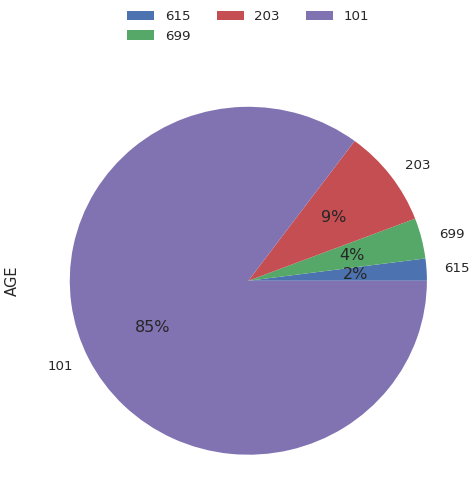

In [29]:
demographicDF = cohorts.getDemographics(1)['pos']
display(demographicDF)


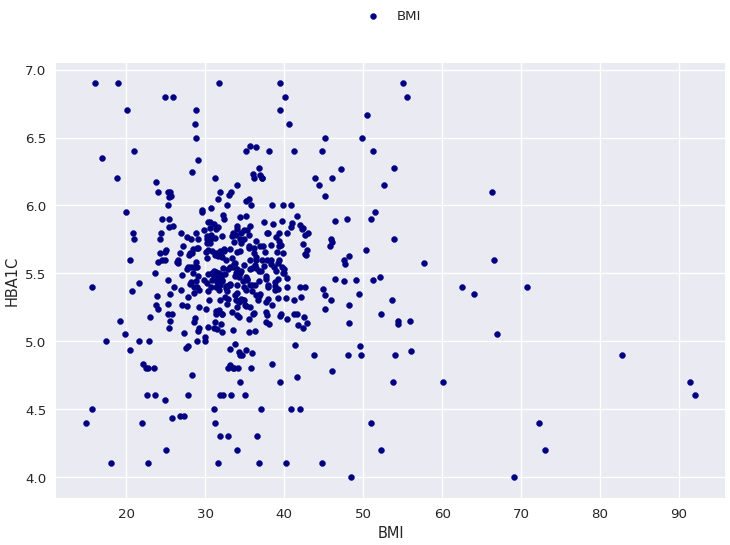

In [15]:
display(demographicDF)


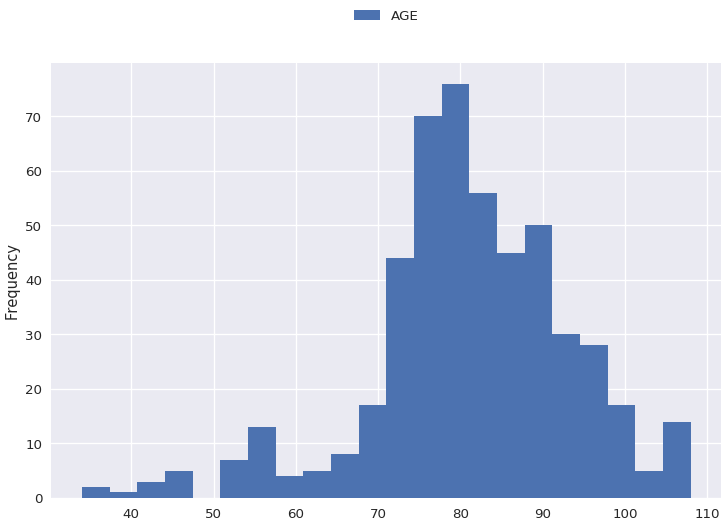

In [16]:
display(demographicDF)


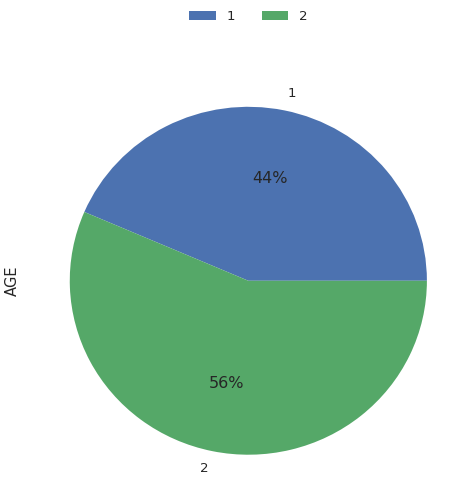

In [17]:
display(demographicDF)

### Page 2: Classsification Model

In [34]:
display(cohorts.getFeatureVectors(1))

STD_GENDER,STD_RACE,AGE,HBA1C,WEIGHT,HEIGHT,BMI,HAS_DISEASE
1,101,94,6.05,74.0,174.5,24.3019351237,pos
1,101,74,6.0,74.6666666667,158.5,29.7213293661,pos
1,101,81,5.8,81.0,188.0,22.9176097782,pos
1,101,82,5.21176470588,74.8823529412,154.647058824,31.310943378,pos
2,101,83,4.7,65.0,195.0,17.094017094,pos
2,101,81,5.55,76.75,154.75,32.0491908101,pos
1,101,52,5.41333333333,69.6666666667,158.133333333,27.8598119147,pos
1,101,79,6.3,87.0,146.0,40.8144117095,pos
2,101,75,6.3,80.0,151.0,35.0861804307,pos
2,101,106,5.74736842105,77.3684210526,146.0,36.2959378179,pos


In [35]:
display(cohorts.getFeatureVectors(2, ['AGE', 'BMI']))

AGE,BMI,HAS_DISEASE
94,24.3019351237,pos
74,29.7213293661,pos
81,22.9176097782,pos
95,38.5300044188,pos
82,31.310943378,pos
83,17.094017094,pos
88,30.6725416697,pos
81,44.6397433215,pos
83,28.3990457295,pos
81,32.0491908101,pos
